In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [8]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [11]:
obj = sc.read_h5ad('../../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Inh"]

In [13]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 8471 cells


In [14]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Inh_1', 'Inh_2', 'Inh_3', 'Inh_4', 'Inh_5', 'Inh_6']:
        new_sub_annotation.append('Inh')
    elif c in ['Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_3', 'Inh_Meis2_4']:
        new_sub_annotation.append('Inh_Meis2')
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


#### Data preparation

In [15]:
sf.data_preparation(obj)

#### Removing general genes

In [16]:
s1 = time.time()

In [17]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [19]:
obj = sf.remove_housekeepingenes(obj, path="../../../../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [20]:
obj = sf.remove_features_pct(obj, group_by="Cell sub annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [21]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell sub annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [22]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.9882533197139939


In [23]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### DNN

In [24]:
s2 = time.time()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                123872    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0


Epoch 00019: val_loss improved from 0.10082 to 0.08195, saving model to weights/best_model_Cell sub annotation.h5
Epoch 20/100
68/68 [==============================] - 0s 4ms/step - loss: 0.0817 - accuracy: 0.9942 - auc: 1.0000 - precision: 0.9979 - recall: 0.9886 - val_loss: 0.0853 - val_accuracy: 0.9882 - val_auc: 0.9999 - val_precision: 0.9893 - val_recall: 0.9841

Epoch 00020: val_loss did not improve from 0.08195
Epoch 21/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9958 - auc: 1.0000 - precision: 0.9993 - recall: 0.9908 - val_loss: 0.0758 - val_accuracy: 0.9882 - val_auc: 0.9999 - val_precision: 0.9887 - val_recall: 0.9817

Epoch 00021: val_loss improved from 0.08195 to 0.07581, saving model to weights/best_model_Cell sub annotation.h5
Epoch 22/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.9960 - auc: 1.0000 - precision: 0.9989 - recall: 0.9906 - val_loss: 0.0837 - val_accuracy: 0.9847 - val_auc: 0.

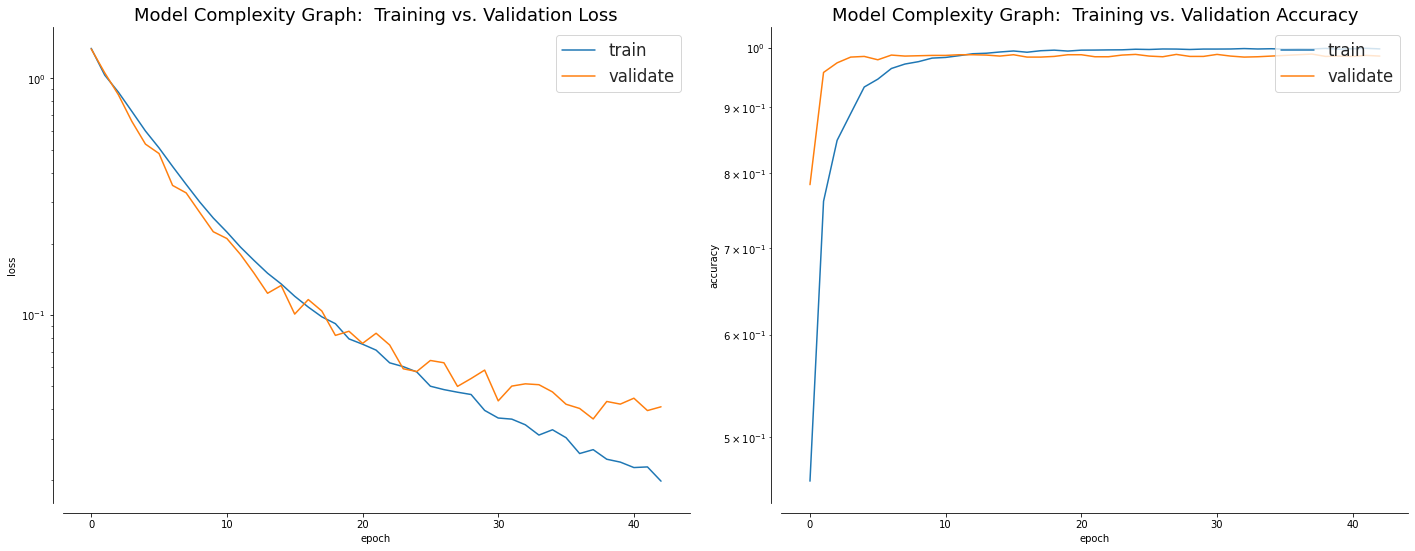

<Figure size 432x288 with 0 Axes>

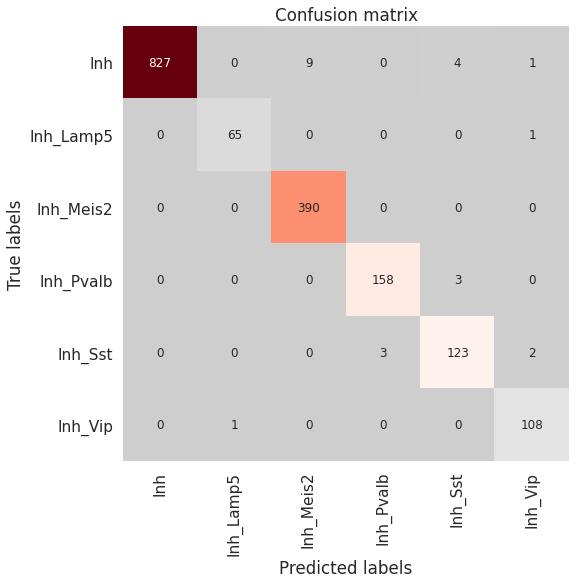

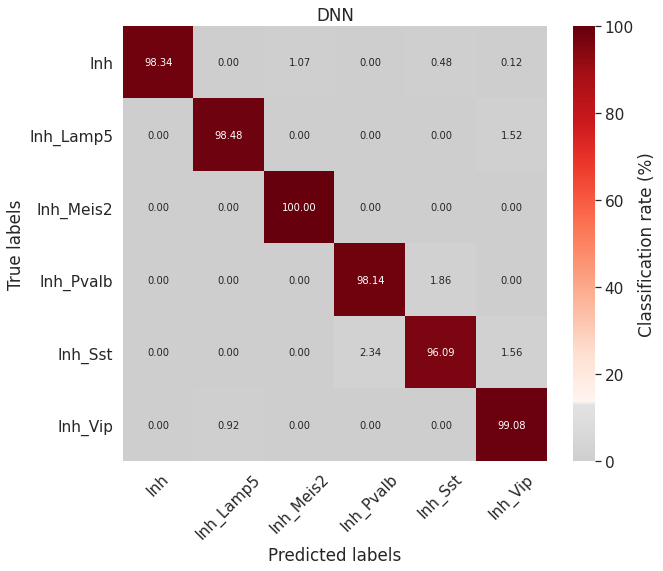

              precision    recall  f1-score   support

         Inh       1.00      0.98      0.99       841
   Inh_Lamp5       0.98      0.98      0.98        66
   Inh_Meis2       0.98      1.00      0.99       390
   Inh_Pvalb       0.98      0.98      0.98       161
     Inh_Sst       0.95      0.96      0.95       128
     Inh_Vip       0.96      0.99      0.98       109

    accuracy                           0.99      1695
   macro avg       0.98      0.98      0.98      1695
weighted avg       0.99      0.99      0.99      1695

53/53 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9894 - auc: 0.9999 - precision: 0.9900 - recall: 0.9888


In [25]:
sf.DNN(obj, group_by="Cell sub annotation", model=None, balance=True, verbose=True, save=True)

#### Shap value

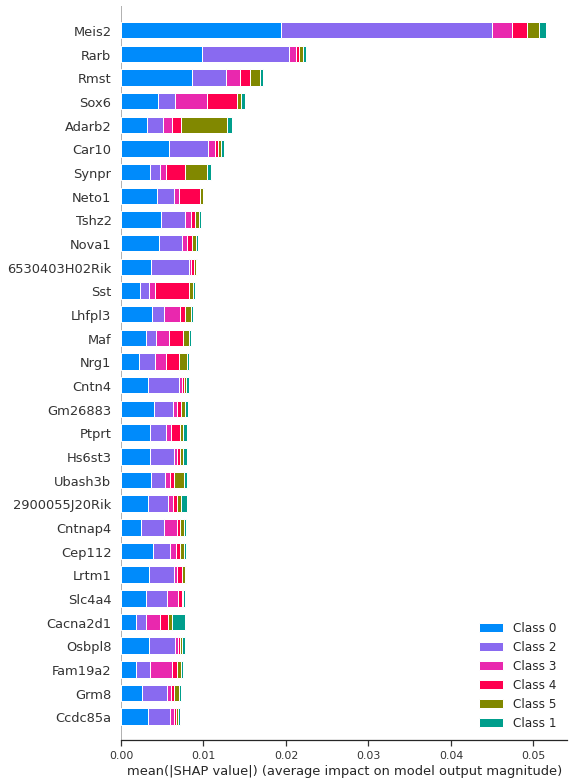

In [26]:
selectedGenes, selectedGenes_dict = sf.run_shap(obj, group_by="Cell sub annotation", model=None, verbose=True, pct=0.1, restrict_top=("local", 20))

In [27]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

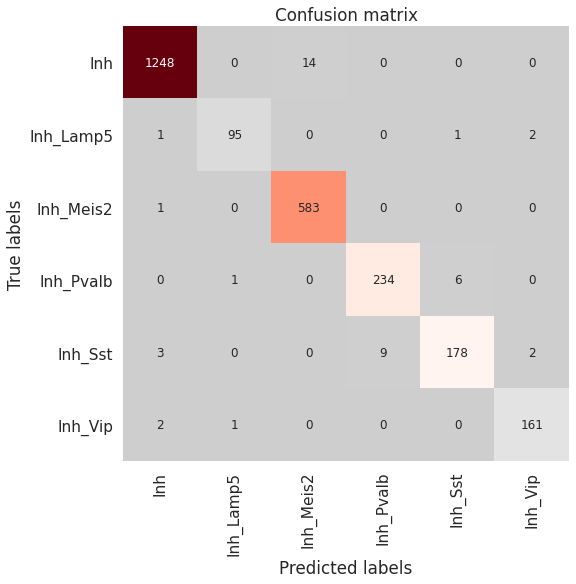

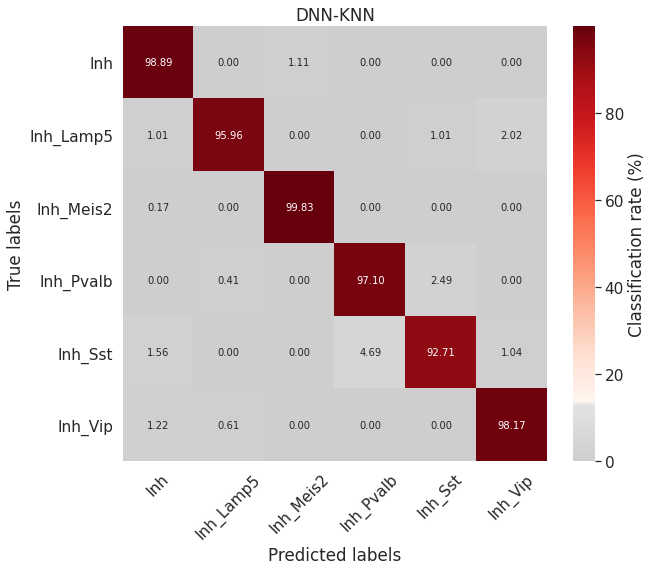

Accuracy: 0.9830841856805664: Misclassification: 0.016915814319433564
              precision    recall  f1-score   support

         Inh       0.99      0.99      0.99      1262
   Inh_Lamp5       0.98      0.96      0.97        99
   Inh_Meis2       0.98      1.00      0.99       584
   Inh_Pvalb       0.96      0.97      0.97       241
     Inh_Sst       0.96      0.93      0.94       192
     Inh_Vip       0.98      0.98      0.98       164

    accuracy                           0.98      2542
   macro avg       0.98      0.97      0.97      2542
weighted avg       0.98      0.98      0.98      2542



In [28]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="DNN-KNN", save=True)

#### Sorting genes per cluster

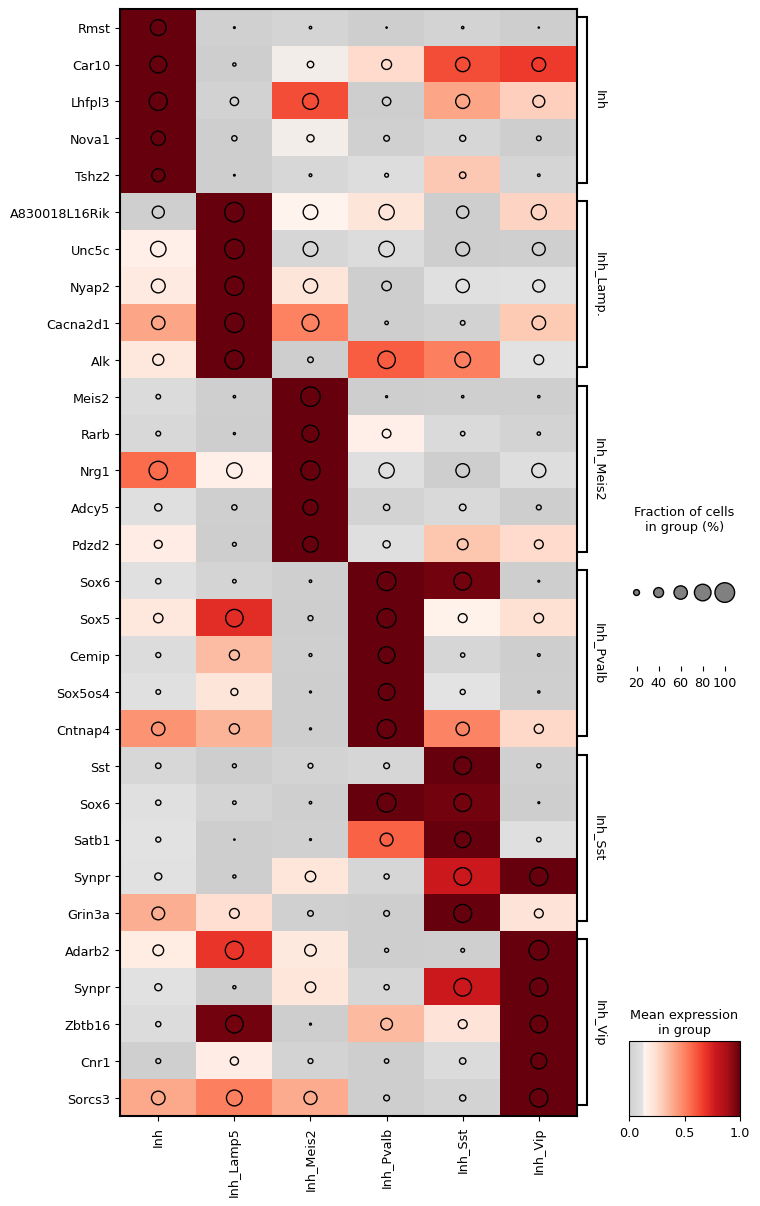

In [29]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell sub annotation", top=5, figsize=(8,14))

In [30]:
e1 = time.time()

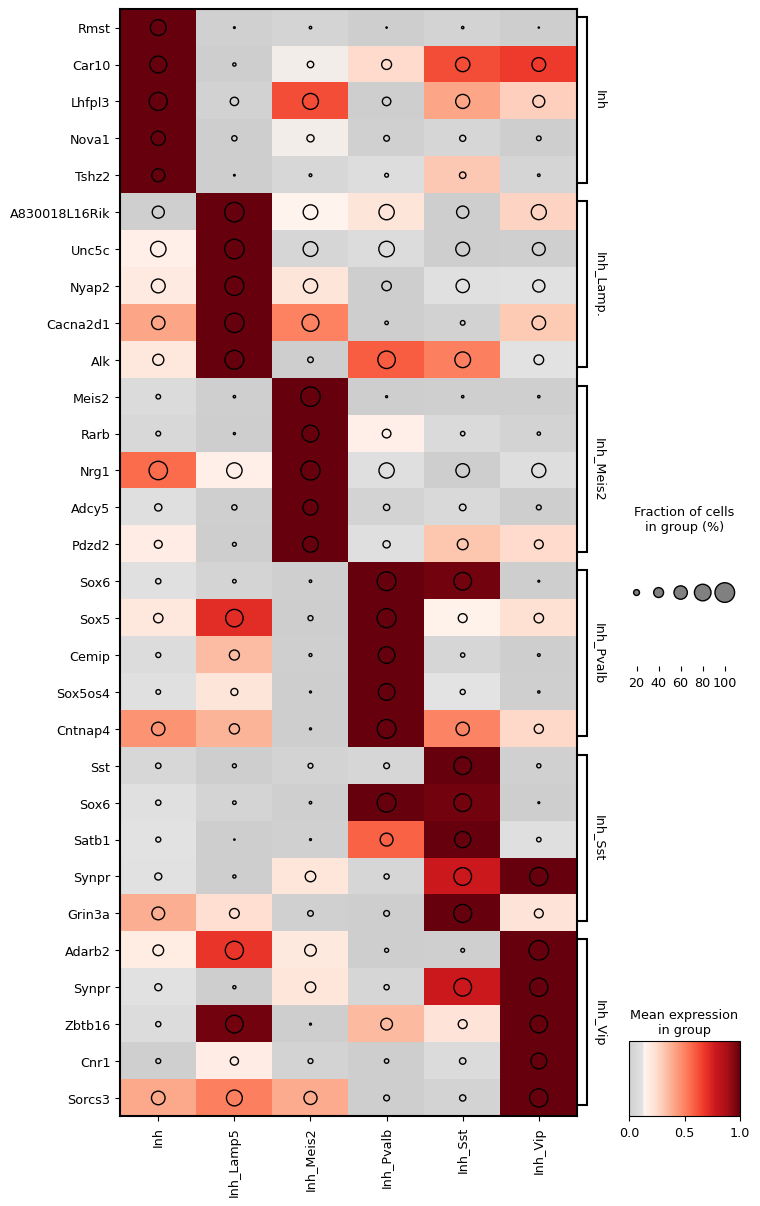

In [31]:
axs.savefig("Figures/DNN_top5_perGroup.pdf")

# Elapsed time

In [32]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

3870 genes across 8471 cells


In [33]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  130.92004537582397


In [34]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  48.48720359802246
